In [1]:
from torchvision import transforms
import numpy as np
import torch
from torchvision.transforms import functional as F
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision
import clip
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, random_split
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

/root/env/deep_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VOCColormap:
    def __init__(self):
        self.colormap = np.array([
            [0, 0, 0],          # background
            [128, 0, 0],        # aeroplane
            [0, 128, 0],        # bicycle
            [128, 128, 0],      # bird
            [0, 0, 128],        # boat
            [128, 0, 128],      # bottle
            [0, 128, 128],      # bus
            [128, 128, 128],    # car
            [64, 0, 0],         # cat
            [192, 0, 0],        # chair
            [64, 128, 0],       # cow
            [192, 128, 0],      # diningtable
            [64, 0, 128],       # dog
            [192, 0, 128],      # horse
            [64, 128, 128],     # motorbike
            [192, 128, 128],    # person
            [0, 64, 0],         # pottedplant
            [128, 64, 0],       # sheep
            [0, 192, 0],        # sofa
            [128, 192, 0],      # train
            [0, 64, 128],       # tvmonitor
            [128, 64, 128],     # ignored/255
        ], dtype=np.uint8)
    
    def apply_colormap(self, mask):
        """Convert segmentation mask to color image"""
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        # Remplacer 255 par 21 pour la visualisation
        colored_mask = np.copy(mask)
        colored_mask[colored_mask == 255] = 21
        colored_mask = colored_mask.astype(int)
        
        # Appliquer la colormap
        return self.colormap[colored_mask]

def visualize_data(images, masks, predictions=None, num_samples=5):
    """
    Visualise les images, masques ground truth et prédictions
    
    Args:
        images: tensor [B, C, H, W] normalisé
        masks: tensor [B, H, W] avec valeurs de classe
        predictions: optional tensor [B, H, W] avec valeurs de classe prédites
        num_samples: nombre d'échantillons à afficher
        save_path: chemin pour sauvegarder la figure
    """
    # Dénormalisation des images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = transforms.Normalize(
        mean=(-mean / std).tolist(),
        std=(1.0 / std).tolist()
    )
    
    # Nombre d'images à afficher
    n = min(num_samples, len(images))
    
    # Configurer la figure
    if predictions is not None:
        fig, axs = plt.subplots(n, 3, figsize=(15, 5*n))
        titles = ['Image', 'Ground Truth', 'Prediction']
    else:
        fig, axs = plt.subplots(n, 2, figsize=(10, 5*n))
        titles = ['Image', 'Ground Truth']
    
    colormap = VOCColormap()
    
    for i in range(n):
        # Image originale
        img = denorm(images[i]).cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Masque ground truth
        mask = masks[i].cpu().numpy()
        colored_mask = colormap.apply_colormap(mask)
        
        if predictions is not None:
            # Prédiction
            pred = predictions[i].cpu().numpy()
            colored_pred = colormap.apply_colormap(pred)
            
            axs[i, 0].imshow(img)
            axs[i, 1].imshow(colored_mask)
            axs[i, 2].imshow(colored_pred)
        else:
            axs[i, 0].imshow(img)
            axs[i, 1].imshow(colored_mask)
        
        # Configurer les sous-plots
        for j, title in enumerate(titles):
            axs[i, j].set_title(f'{title} - Sample {i+1}')
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_training_data(train_loader, num_samples=5):
    """Visualiser quelques échantillons d'entraînement"""
    images, masks = next(iter(train_loader))
    visualize_data(images, masks)

def visualize_validation_results(model, val_loader, device, num_samples=5):
    """Visualiser les résultats sur quelques échantillons de validation"""
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(val_loader))
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        
        visualize_data(images, masks, predictions)

In [3]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=21, prompt_length=30, device="cuda"):
        super().__init__()
        self.mask_generator = deeplabv3_resnet101(pretrained=True).to(device)
        self.clip_model, self.clip_preprocess = clip.load("ViT-B/32", device=device)
        
        # Initialize prompts with semantic meaning instead of random
        self.prompts = nn.Parameter(self.initialize_semantic_prompts(
            num_classes, prompt_length, device))
        
        # Freeze CLIP
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        self.voc_classes = ['background', 'aeroplane', ...]  # your classes
        
    def initialize_semantic_prompts(self, num_classes, prompt_length, device):
        # Initialize prompts using CLIP text features
        text_features = []
        for class_name in self.voc_classes:
            text = clip.tokenize(f"a photo of a {class_name}").to(device)
            with torch.no_grad():
                text_feature = self.clip_model.encode_text(text)
            text_features.append(text_feature)
        text_features = torch.cat(text_features, dim=0)
        
        # Expand to prompt length
        prompts = text_features.unsqueeze(1).expand(-1, prompt_length, -1)
        return prompts

    def forward(self, images):
        # Generate initial masks
        mask_output = self.mask_generator(images)
        masks = mask_output['out']
        
        # Apply semantic prompt learning
        refined_masks = self.apply_prompt_learning(images, masks)
        
        return refined_masks

class VOCDatasetWithCLIP(VOCSegmentation):
    def __init__(self, root, year='2012', image_set='train', transform=None, target_transform=None):
        super().__init__(root, year=year, image_set=image_set, transform=transform, target_transform=target_transform)
        
    def __getitem__(self, index):
        # Charger l'image et le masque à partir de leurs chemins
        img = Image.open(self.images[index]).convert("RGB")  # Charger l'image en RGB
        mask = Image.open(self.masks[index])  # Charger le masque

        # Appliquer les transformations
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        
        # Remplacer les valeurs de masque 255 (ignored) par -1
        mask = mask.long()  # Assurez-vous que le masque est en type long
        mask[mask == 255] = -1
        
        return img, mask
    
def match_loss(foreground_features, text_features, background_features, lambda_b):
    foreground_similarity = torch.cosine_similarity(foreground_features, text_features, dim=-1)
    foreground_similarity = torch.clamp(foreground_similarity, min=1e-6)
    background_similarity = torch.cosine_similarity(background_features, text_features, dim=-1)
    background_similarity = torch.clamp(background_similarity, min=0.0, max=1 - 1e-6)
    loss = -torch.log(foreground_similarity).mean() - lambda_b * torch.log(1 - background_similarity).mean()
    return loss

def prompt_loss(background_prompts, text_features, background_features, lambda_T):
    averaged_prompt = background_prompts.mean(dim=0)
    prompt_alignment = torch.cosine_similarity(averaged_prompt.unsqueeze(0), background_features, dim=-1)
    prompt_alignment = torch.clamp(prompt_alignment, min=1e-6)
    prompt_repulsion = torch.cosine_similarity(averaged_prompt.unsqueeze(0), text_features, dim=-1)
    prompt_repulsion = torch.clamp(prompt_repulsion, min=0.0, max=1 - 1e-6)
    loss = -torch.log(prompt_alignment).mean() - lambda_T * torch.log(1 - prompt_repulsion).mean()
    return loss

def refine_loss(foreground_features, background_prompts):
    averaged_prompt = background_prompts.mean(dim=0)
    refinement = torch.cosine_similarity(foreground_features, averaged_prompt.unsqueeze(0), dim=-1)
    refinement = torch.clamp(refinement, min=0.0, max=1 - 1e-6)
    return - torch.log(1 - refinement).mean()

def compute_total_loss(self, images, masks, pred_masks):
    total_loss = 0
    
    matching_loss = self.compute_matching_loss(images, pred_masks)
    
    prompt_loss = self.compute_prompt_learning_loss(images, pred_masks)
    
    refinement_loss = self.compute_refinement_loss(images, pred_masks)
    
    total_loss = matching_loss + self.lambda_p * prompt_loss + self.lambda_r * refinement_loss
    
    return total_loss

def train_one_epoch(model, train_loader, optimizer, device, lambdas):
    model.train()
    total_loss = 0
    
    for images, masks in tqdm(train_loader):
        torch.cuda.empty_cache()
        images = images.to(device)  # [B, 3, H, W]
        masks = masks.to(device)    # [B, H, W]
        
        optimizer.zero_grad()
        
        # Génération des masques
        pred_masks = model(images)  # [B, C, H, W]
        
        # Création de tous les masques foreground et background d'un coup
        # Convertir les masques prédits en probabilités
        pred_masks = torch.sigmoid(pred_masks)  # [B, C, H, W]
        
        # Préparer tous les textes pour toutes les classes
        text_inputs = [f"a photo of {model.voc_classes[c]}" for c in range(1, pred_masks.shape[1])]
        text_tokens = clip.tokenize(text_inputs).to(device)
        
        # Encoder tous les textes d'un coup
        with torch.no_grad():
            text_features = model.clip_model.encode_text(text_tokens)  # [C-1, D]
        
        class_total_loss = 0
        # Pour chaque classe (sauf background)
        for c in range(1, pred_masks.shape[1]):
            # Trouver les images qui contiennent cette classe
            class_present = (masks == c).any(dim=1).any(dim=1)
            if not class_present.any():
                continue
                
            # Sélectionner les images pertinentes
            relevant_images = images[class_present]  # [B', 3, H, W]
            relevant_masks = pred_masks[class_present, c]  # [B', H, W]
            
            # Créer les images foreground et background
            foreground = relevant_images * relevant_masks.unsqueeze(1)  # [B', 3, H, W]
            background = relevant_images * (1 - relevant_masks.unsqueeze(1))  # [B', 3, H, W]

            # Encoder toutes les images foreground et background d'un coup
            fore_features = model.clip_model.encode_image(foreground)  # [B', D]
            back_features = model.clip_model.encode_image(background)  # [B', D]
            
            class_match_loss = match_loss(fore_features, text_features[c-1].unsqueeze(0), back_features, lambdas["lambda_b"])
            class_prompt_loss = prompt_loss(model.prompts[c], text_features[c-1].unsqueeze(0), back_features, lambdas["lambda_T"])
            class_refine_loss = refine_loss(fore_features, model.prompts[c])
            class_total_loss += (class_match_loss + lambdas["lambda"] * class_refine_loss + class_prompt_loss)
            #print("all", class_match_loss, class_prompt_loss, class_refine_loss, class_total_loss)
        
        # Normaliser la loss par le nombre de classes
        loss = class_total_loss / (pred_masks.shape[1] - 1)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def calculate_miou(pred_classes, true_masks, num_classes=21):
    valid_mask = true_masks != -1
    
    # Convertir en numpy et aplatir
    pred_flat = pred_classes[valid_mask].cpu().numpy().flatten()
    true_flat = true_masks[valid_mask].cpu().numpy().flatten()
    
    # Calculer la matrice de confusion
    confusion_mat = confusion_matrix(
        true_flat, 
        pred_flat,
        labels=list(range(num_classes))
    )
    
    return confusion_mat

def validate(model, val_loader, device, lambdas):
    model.eval()
    confusion_mat_total = None
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            torch.cuda.empty_cache()
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            pred_masks = model(images)
            
            # Calcul du mIoU avec argmax pour avoir les classes prédites
            pred_classes = torch.argmax(pred_masks, dim=1)  # [B, H, W]
            batch_conf_mat = calculate_miou(pred_classes, masks)
            
            if confusion_mat_total is None:
                confusion_mat_total = batch_conf_mat
            else:
                confusion_mat_total += batch_conf_mat
            
            # Pour la matching loss, on utilise sigmoid pour avoir des masques soft
            pred_masks_soft = torch.sigmoid(pred_masks)  # [B, C, H, W]
            
            # Préparer tous les textes
            text_inputs = [f"a photo of {model.voc_classes[c]}" for c in range(1, pred_masks.shape[1])]
            text_tokens = clip.tokenize(text_inputs).to(device)
            
            text_features = model.clip_model.encode_text(text_tokens)
            
            class_total_loss = 0
            for c in range(1, pred_masks.shape[1]):
                class_present = (masks == c).any(dim=1).any(dim=1)
                if not class_present.any():
                    continue
                    
                # Sélectionner les images pertinentes
                relevant_images = images[class_present]  # [B', 3, H, W]
                relevant_masks = pred_masks_soft[class_present, c]  # [B', H, W]
                
                # Créer les images foreground et background
                foreground = relevant_images * relevant_masks.unsqueeze(1)  # [B', 3, H, W]
                background = relevant_images * (1 - relevant_masks.unsqueeze(1))  # [B', 3, H, W]
                
                fore_features = model.clip_model.encode_image(foreground)
                back_features = model.clip_model.encode_image(background)
                
                class_match_loss = match_loss(fore_features, text_features[c-1].unsqueeze(0), back_features, lambdas["lambda_b"])
                class_prompt_loss = prompt_loss(model.prompts[c], text_features[c-1].unsqueeze(0), back_features, lambdas["lambda_T"])
                class_refine_loss = refine_loss(fore_features, model.prompts[c])
                class_total_loss += (class_match_loss + lambdas["lambda"] * class_refine_loss + class_prompt_loss)
        
            # Normaliser la loss par le nombre de classes
            loss = class_total_loss / (pred_masks.shape[1] - 1)
            total_loss += loss.item()
    
    # Calcul final des métriques
    intersection = np.diag(confusion_mat_total)
    gt_set = confusion_mat_total.sum(axis=1)
    pred_set = confusion_mat_total.sum(axis=0)
    union = gt_set + pred_set - intersection
    
    class_ious = intersection / (union + 1e-6)
    valid_classes = union > 0
    miou = class_ious[valid_classes].mean()
    
    # Calculer la loss moyenne
    avg_loss = total_loss / len(val_loader)
        
    return avg_loss, miou

def mask_transform(mask):
    # Redimensionner avec interpolation nearest pour préserver les classes
    mask = F.resize(mask, (224, 224), interpolation=Image.NEAREST)
    # Convertir en numpy array pour manipuler les valeurs discrètes
    mask = np.array(mask, dtype=np.uint8)  # np.uint8 pour correspondre aux valeurs originales
    return torch.from_numpy(mask) 

In [4]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 60
batch_size = 32
learning_rate = 5e-4
lambda_b = 2.4
lambdas =  {"lambda_b": 2.4, "lambda_T":  0.02, "lambda":0.05}

# Data loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VOCDatasetWithCLIP(root='./data', image_set="train", transform=transform, target_transform=mask_transform)
val_dataset = VOCDatasetWithCLIP(root='./data', image_set="val", transform=transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [5]:
print("train", len(train_dataset), "val", len(val_dataset))

train 1464 val 1449


Visualisation des données d'entraînement:


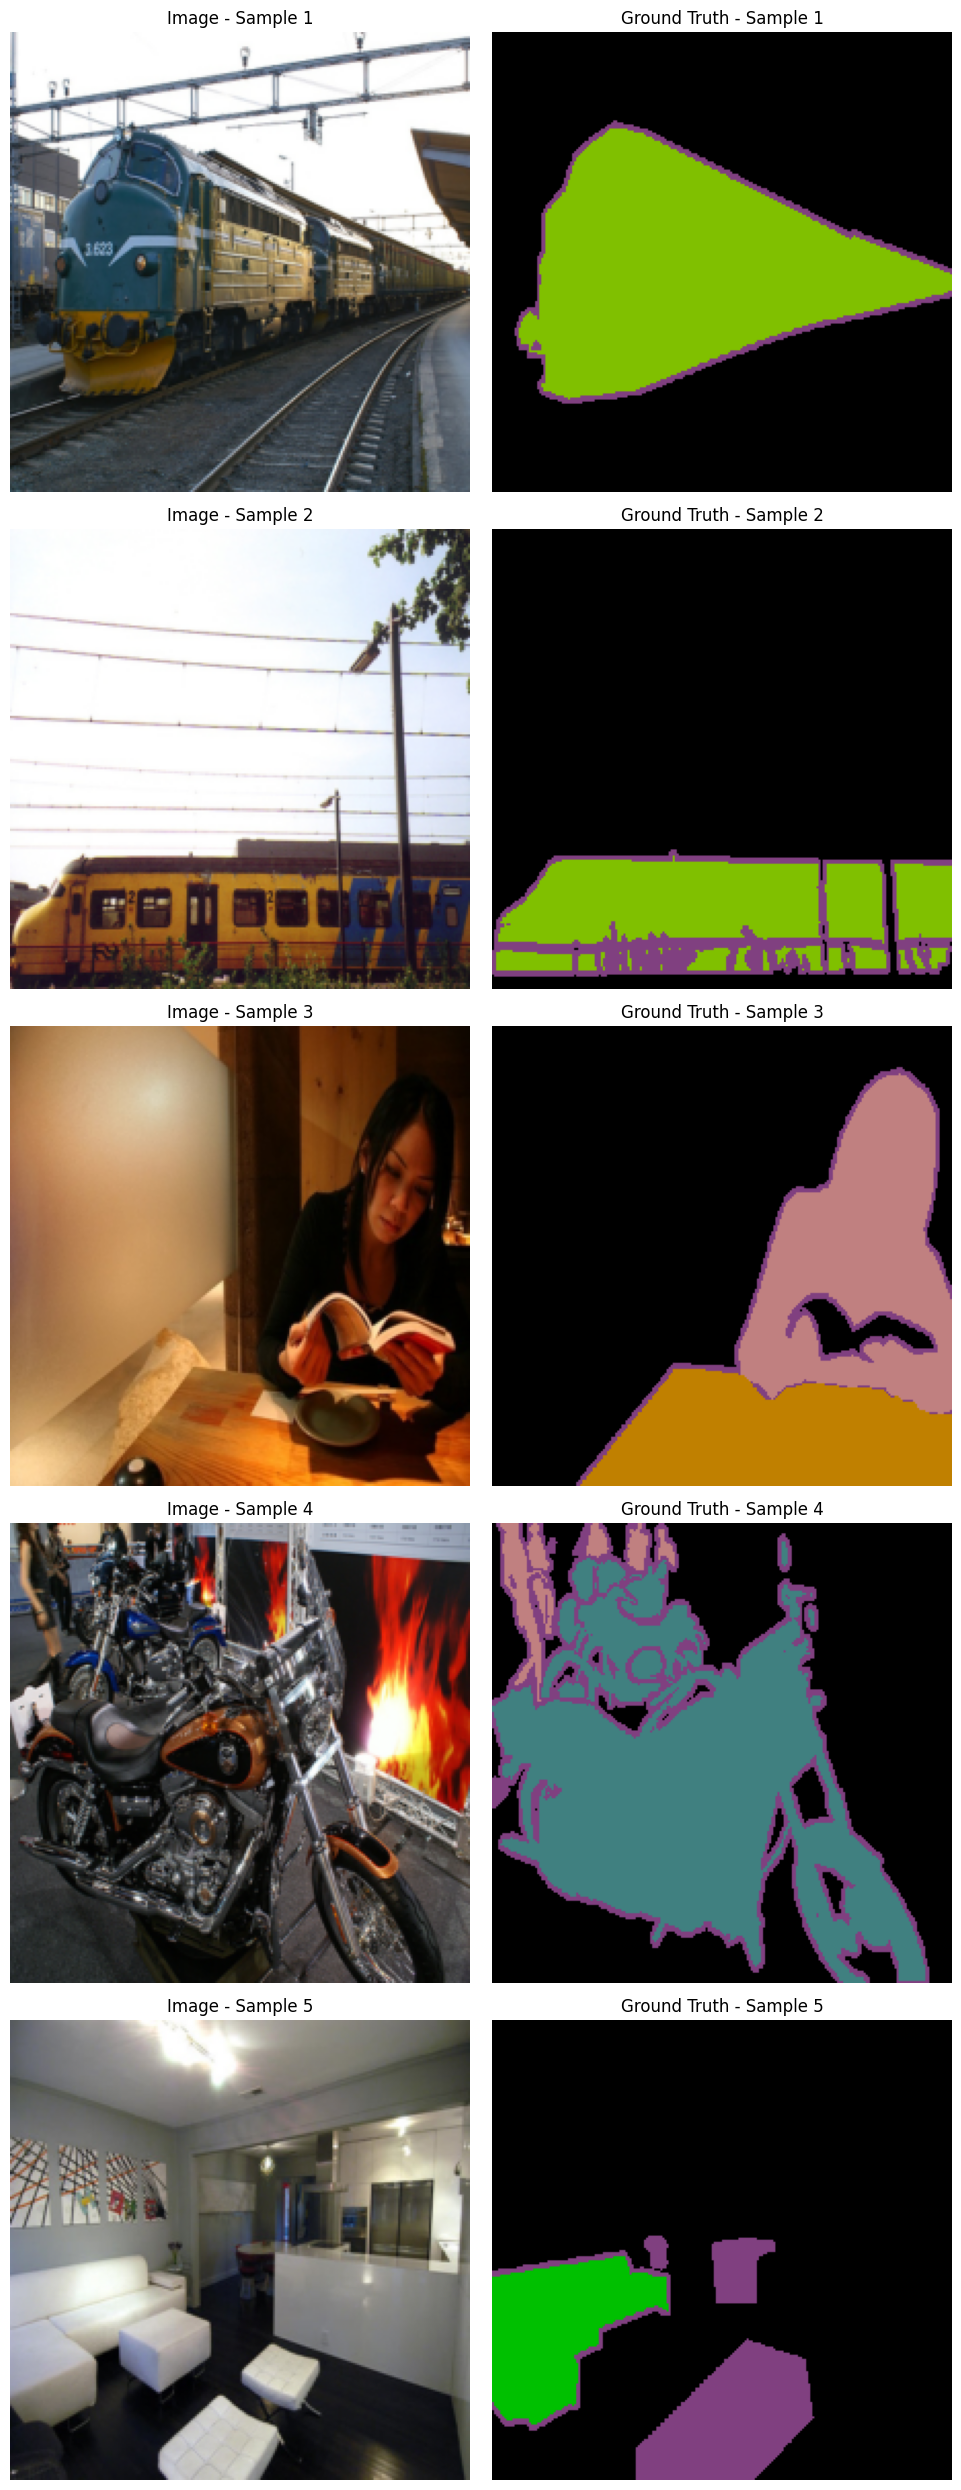

In [6]:
print("Visualisation des données d'entraînement:")
visualize_training_data(train_loader)

In [7]:
# Création du modèle
model = CustomModel().to(device)

In [8]:
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(profile="full")

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

torch.cuda.empty_cache()
# Boucle d'entraînement
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device, lambdas)
    val_loss, val_miou = validate(model, val_loader, device, lambdas)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss} - Validation Loss: {val_loss} - Validation mIoU: {val_miou:.4f}")

    scheduler.step()

  0%|          | 0/46 [00:00<?, ?it/s]

In [10]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'model.pth')


Visualisation des résultats de validation:


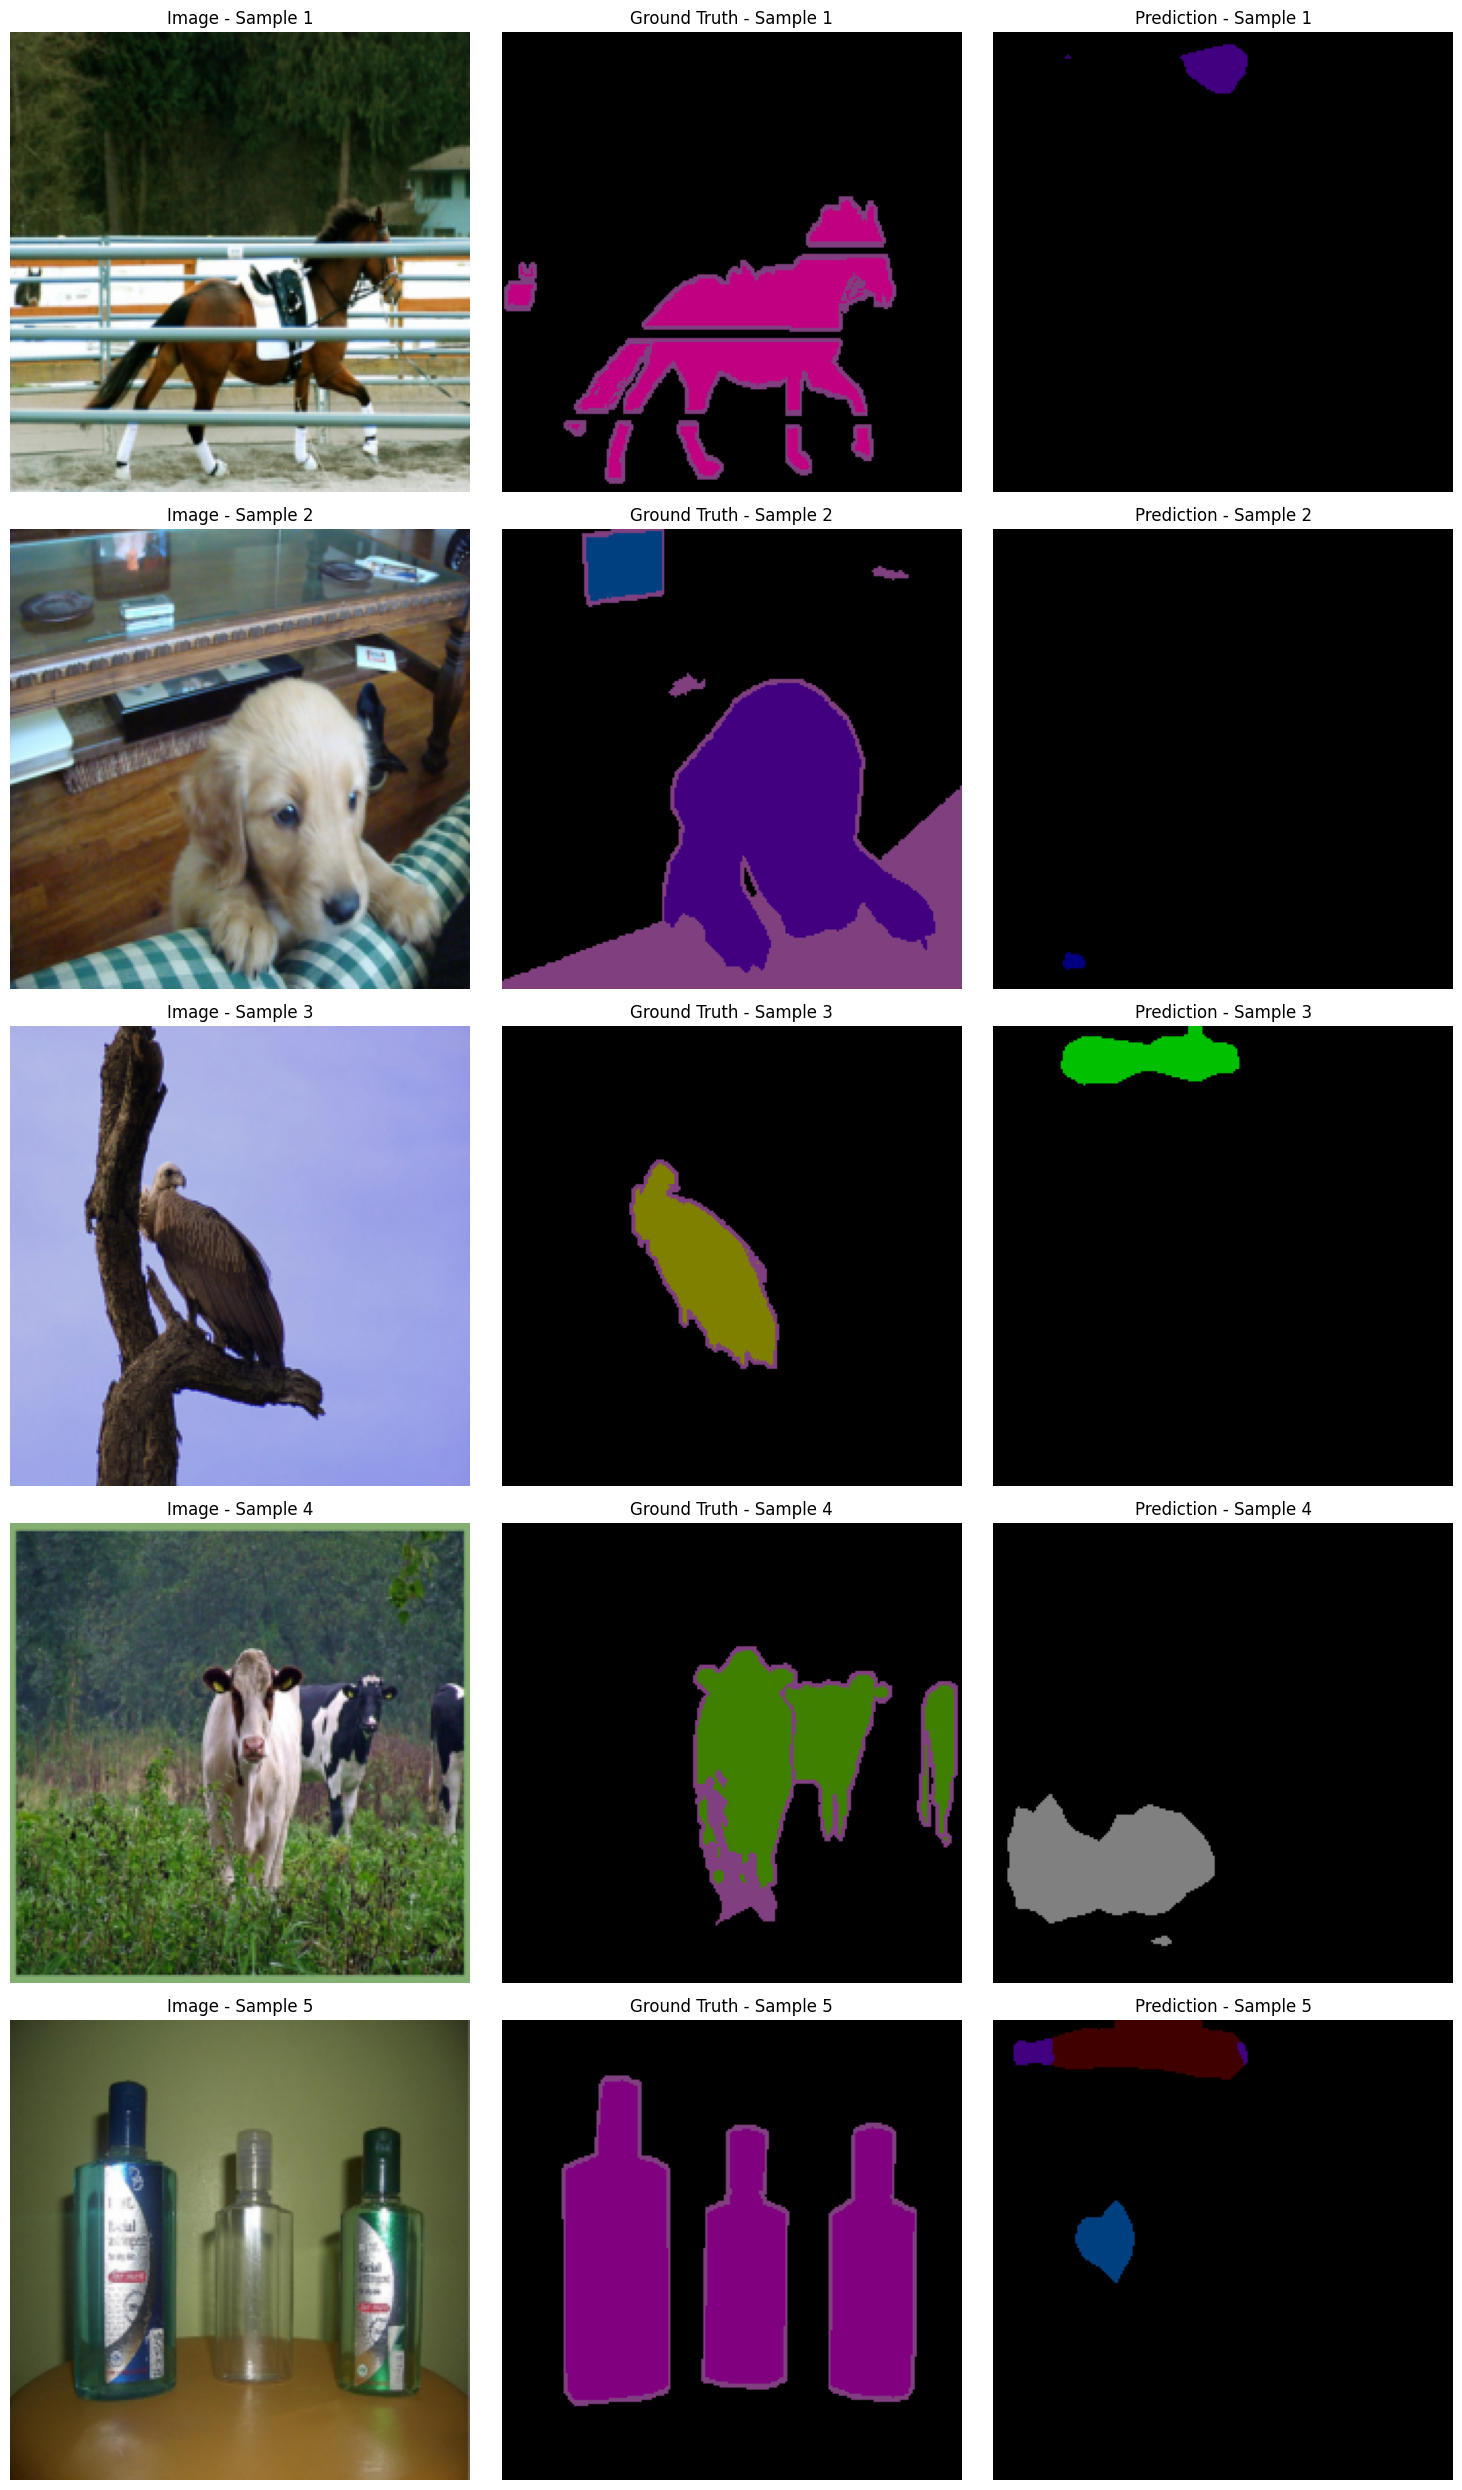

In [11]:
print("\nVisualisation des résultats de validation:")
visualize_validation_results(model, val_loader, device)